# Passing information using Memory.

## Authors of homework:
+ Aleksandra Jamróz
+ Mireia Alba Kesti Izquierdo

When we need to share information, we use the memory to pass it to all parallel threads.

We have to take care how we use the memory access, and the scope where the variables exist, and, in the case of Python, how the interpreter handles it.

In Python, we will use the global variables defined in the modules, to store the common information which will be used by all tasks.

One important thing: The use of this memory information MUST be used n a Read Only policy, to avoid any kind of hazzards. *Note: Python does not implement a Read Only policy, it is a Programmer way of programming*

* _Read Only_ memory access to the shared data. In this case, we can call the global variable from our distributed code

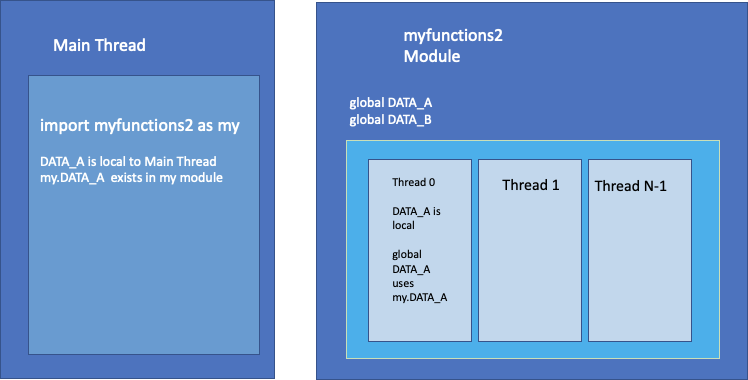

In [1]:
%matplotlib inline
import multiprocessing as mp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

In [2]:
import myfunctions2 as my

Everytime you make changes in the python file *myfunctions.py*, you have to reload them, to update the changes.

In [3]:
import importlib

In [5]:
importlib.reload(my)

<module 'myfunctions2' from '/home/yamroza/Documents/SEMV/MassiveComputing/Session_5/myfunctions2.py'>

Now, we have to define the number of parallel processes

In [6]:
NUMCORES = 8

## Baseline: sequential matrix multiplication:

Here we will implements the sequential matrix multiplication. Remember, to calculate a matrix multiplication:
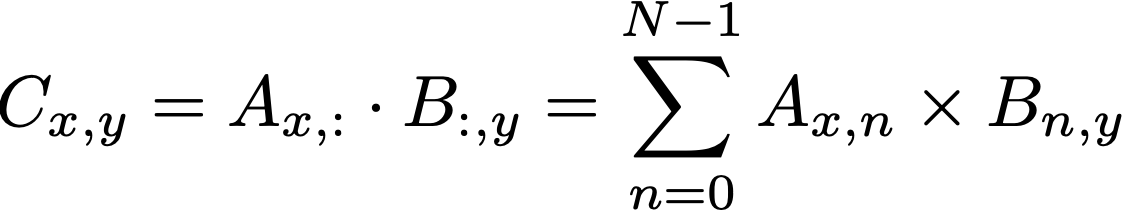

Where A,B are matrices of size: For A, M rows, N columns, for B N rows, P columns, C is the result matrix of size, MxP.

In [7]:
M = 1000
N = 500
P = 750
matrix_A = np.random.rand(M,N)
matrix_B = np.random.rand(N,P)

Now, we will implement the function to multiply 2 matrices

In [8]:
def seq_mat_mult(A,B):
    (M,N) = A.shape
    (_,P) = B.shape
    C = np.zeros((M,P))
    for x in range(M):
        for y in range(P):
            accu = 0
            for n in range(N):
                accu += A[x,n] * B[n,y]
            C[x,y] = accu
    return C

In [ ]:
%%time
C = seq_mat_mult(matrix_A,matrix_B)
# lasts around 3 minutes

## First example: Implement a distributed matrix multiplication using shared memory (read only access policy)
We will create 2 matrices and multiply them two.
The distributed matrices multiplication distributes the rows of the first matrix, share the second matrix between processes, and calculate the new result row:
The steps will be:

* Define the global variables
* Define our distributed function
* Adapt our data to distribute them in the pool of process
* Create the distribute of process pool
* Execute and collect


Here we define our data

In [ ]:
matrix_B.shape
my.init_second(matrix_B)

We define a distributed parallel multiplication

In [ ]:
# Here, we calculate the matrix_1 shape to adapt it to our parallel process
(rows,columns) = matrix_A.shape

In [ ]:
# We can verify if our algorithm works in sequential order
for f in range(rows):
    v = matrix_A[f,:]
    c = my.parallel_matmul(v)

# doesn't do anything?

In [ ]:
# We split our first matrix in a list of rows
v = list()
for f in range(rows):
    v.append(matrix_A[f,:])

In [ ]:
# print (v[0])
np.shape(v)

In [ ]:
# And execute the parallel section 
def matrix_multiplication(v):
    with mp.Pool(processes = NUMCORES, initializer = my.init_second, initargs = [matrix_B]) as p:
        result = p.map(my.parallel_matmul, v)
    return result

In [ ]:
%%time
result = matrix_multiplication(v)

In [ ]:
final = np.matrix(result)

In [ ]:
print(final)

In [ ]:
print(np.matmul(matrix_A,matrix_B))

Why does this work? Because the shared memory "matrix_2" is a read only shared memory
The problem is when we need a shared read/write memory

Advantages when we use "read/only" memory data:
* You avoid any memory hazard: your data is stable
* If you are in a shared memory computer, is fastest

Disadvanatages:
* Memory consumption
* Shared memory communication

## Practical Assigment:

### Image filtering: 

When we filter an image, we have to apply a filter mask over each position in an image. For example:
A smooth filter calculate the value in a pixel (x,y) position as the average value of the n neighborhoods. 
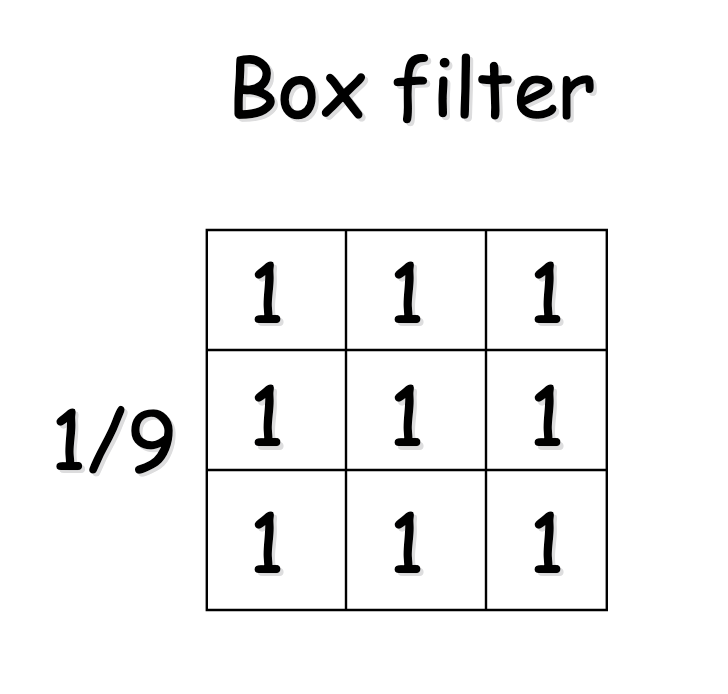

With this type of filters, if we need to calculate the filtered pixel in the position (x,y), we will need to calculate the product of the pixels in the positions (x-1,y-1)+(x,y-1)+(x+1,y-1)+(x-1,y)+(x,y)+(x+1,y)+(x-1,y+1)+(x,y+1)+(x+1,y1+1), against the filter mask.

Things to take care:

* The algorithm must be independent of the image size
* The values will been between 0 an 255, and the results should be integer values between those values.
* To calculate the borders, we use the next available value. For example: if y is the row, for the upper border (where y=0) we will replace (x-1,y)+(x,y)+(x+1,y)+(x-1,y)+(x,y)+(x+1,y)+(x-1,y+1)+(x,y+1)+(x+1,y1+1).
* The images have 3 layers depth, so, we need to apply to each one of the 3 layers the filter mask

You will have 2 matrices: Image and Filter. The first one will be a preloaded image, the second matrix is the filter mask.

Things to do before starts:
* Which information you will distribute? Pixel position? row position? column position?
* Which information will you collect? Pixel, columns? rows?
* How will you collect the information?


In [9]:
cat_image = np.array(Image.open('cat.jpg'))

In [10]:
filter_mask = np.ones((3,3))/9

In [11]:
print(cat_image.shape)

(1200, 1600, 3)


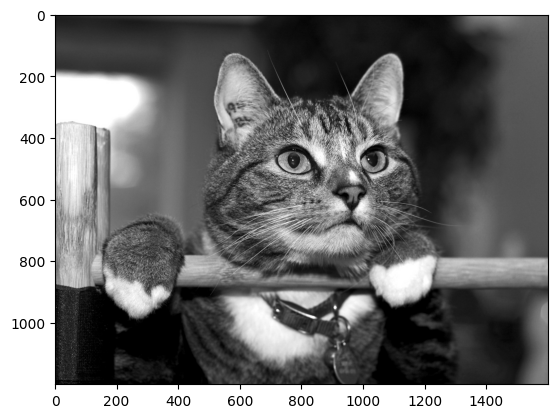

In [12]:
plt.figure()
plt.imshow(cat_image)

In [28]:

def filter_image(my_image, numcores):
    v = range(my_image.shape[0])
    with mp.Pool(numcores, initializer = my.init_globalimage, initargs = [my_image,filter_mask]) as p:
        result = p.map(my.parallel_filtering_image, v)
    return result

In [35]:
%%time
filtered_cat_image = filter_image(cat_image, 8)

CPU times: user 1.03 s, sys: 908 ms, total: 1.94 s
Wall time: 17.1 s


Time for various NUMCORES values:
| core number | time |
|----|--------|
| 1  | 1min 2s|
| 2  | 33.1 s |
| 4  | 19.5 s |
| 8  | 16.3 s |
| 16 | 17 s   |
| 32 | 16.8 s |
| 64 | 16.5 s |
| 128| 17.1 s|


To have clearer view, first I tried filtering the image with only one core. I took a little above a minute. Using 2 cores I achieved 2x better result. After executing image filtering with different core numbers my conclusion is, that for my computer optimal value is 8. Range below 8 give results that leave space for improvement, while range above 8 give similar results, but I noticed that it is much more challenging for a computer to manage larger core numbers. System appeared to work worse while executing 128 parallel threads - for example visual studio code had problems with projecting time in real time - it had breaks between showing next seconds values.

In [36]:
def reconstruct_image(shape, image):
    new_image = np.ndarray(shape,dtype=np.uint8)
    for r in range(len(image)):
        new_image[r] = image[r]
    return new_image

In [42]:
fimage = reconstruct_image(cat_image.shape, filtered_cat_image)

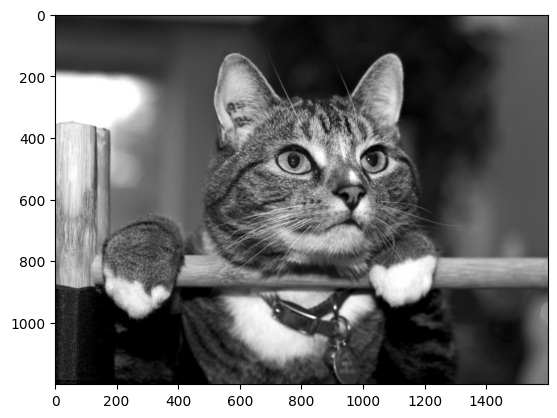

In [41]:
# displaying filtered image
plt.figure()
plt.imshow(fimage)

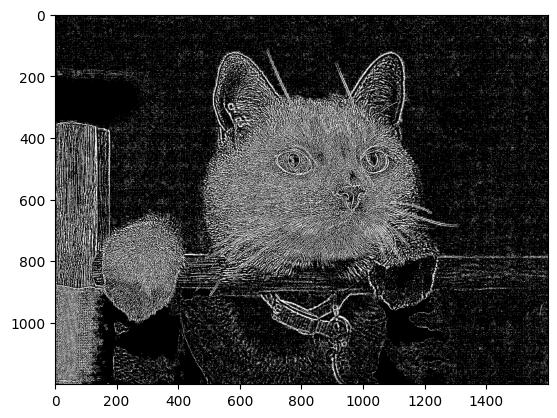

In [40]:
# difference picture between original and filtered one
plt.figure()
plt.imshow(cat_image - fimage)